<a href="https://colab.research.google.com/github/Ana-AlonsoCanizares/LHMProgram/blob/main/LMHSS23_Day1_ARM_PixelRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Motivated from Pieter Abeel Course Unsupervised Deep Learning at UC Berkely

In [ ]:
# p(x_i | x_{i-1}, x_{i-2},...,x_1)
# I[i,j] (i,j) \in{1,2,...,28}, I[i,j] \in {0,1}
# x_inp = vecotr of size 28*28

In [2]:
import numpy as np
import matplotlib.pyplot as plt


#PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models,transforms
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
%matplotlib inline



In [3]:
device = torch.device('cuda') # Try to use a GPU instead of a CPU
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
input_shape = (1,14,14) # Defining the shape of the input tensor (single channel (grayscale) and 14x14 pixels)

In [4]:
# MNIST
def mnist(batch_sz, valid_size=0.2, shuffle=True, random_seed=2000):
    num_classes = 10
    # Defining the transformations to be applied to the data. Resize and convert to a tensor
    transform_train = transforms.Compose([
                        transforms.Resize((input_shape[1],input_shape[2])),
                        transforms.ToTensor(),
                    ])

    transform_valid = transforms.Compose([
                        transforms.Resize((input_shape[1],input_shape[2])),
                        transforms.ToTensor(),
                    ])

    transform_test = transforms.Compose([
                        transforms.Resize((input_shape[1],input_shape[2])),
                        transforms.ToTensor(),
                    ])


    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    valid_data = MNIST(root='./datasets', train=True, download=True, transform=transform_valid)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train)) # Calculates the number of samples to be included in the validation set
    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]

    # Samplers for the training and validation datasets, respectively.
    # Samplers are used to define the strategy for sampling data from the dataset during training.
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # The data loaders allow iterating over the datasets in batches, which is useful for training and evaluating models.
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz, sampler=train_sampler,pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_sz, sampler=valid_sampler,pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, valid_loader, test_loader


In [5]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data
train_loader, valid_loader, test_loader=mnist(batch_sz)

100%|██████████| 9912422/9912422 [00:00<00:00, 182782516.68it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 31204454.87it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 125990880.21it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6481976.44it/s]


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



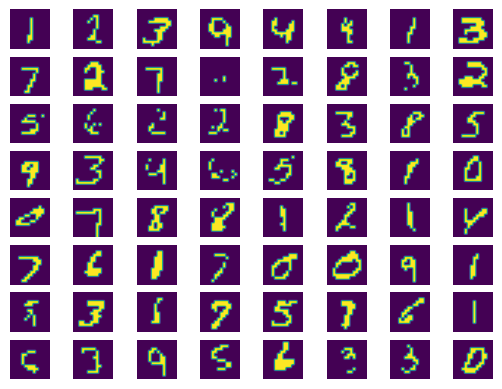

In [7]:
batch = next(iter(train_loader)) # This line gets a batch of data from the train_loader data loader. The next(iter(...)) is used to get the next batch of data. Each batch consists of input images and their corresponding labels.

# It compares each pixel value of the batch with 0.5 and converts the result to a binary value (0 or 1) using the 1.0* multiplication.
# This creates a binary tensor X where values above 0.5 become 1 (white) and values below or equal to 0.5 become 0 (black).
X = 1.0*(batch[0]>0.5) # Umbral
for i in range(X.shape[0]):
  plt.subplot(8,8,i+1)
  plt.imshow(X[i,0,:,:])
  plt.axis("off")

In [6]:
from torchvision.utils import make_grid
def append_location_mine(x, device):

  # Creates a 1D tensor containing values from 0 to input_shape[1]-1. Then divides the tensor by input_shape[1]-1, normalization.
  idxs = torch.arange(input_shape[1]).float() / (input_shape[1]-1)  # Scale to [0, 1]

  # Constructs a 2D tensor locs that represents the meshgrid of the idxs tensor. Creates a grid of 2D spatial coordinates by combining every pair of values from idxs. The resulting tensor has the shape (input_shape[1], input_shape[1], 2).
  locs = torch.stack(torch.meshgrid(idxs, idxs), dim=-1)
  locs = locs.permute(2, 0, 1).contiguous().unsqueeze(0).repeat(x.shape[0], 1, 1, 1)

  # Concatenates the locs tensor to x along the channel dimension (dim=1). It appends the spatial location information to the input tensor.
  locs = locs.to(device)

    x = torch.cat((x, locs), dim=1)
    return x

def visualize_batch(batch_tensor, nrow=8, title='', figsize=None):

  # Creates a grid image from the batch tensor. Reshapes the batch tensor into a grid, with "nrow" images per row, and creates a single image where the images are tiled together.
  grid_img = make_grid(batch_tensor, nrow=nrow)
  plt.figure(figsize=figsize)
  plt.title(title)

  # The grid_img tensor is permuted to have dimensions (height, width, channels) before visualization.
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off')
  plt.show()


In [ ]:
# X =(x1, x2,----, xN)
# X ~ p(X)
# p(X) = p(x1)* p(x2|x1)* p(x3|x2,x1)*....* p(x_{N-1}|x_{N-2},...,x1)* p(x_N|x_{N-1},...,x1)
# x1 ~ p(x1)
# x2 ~ p(x2| x1)
# x3 ~ p(x3| x2, x1)
#
#
# xN ~ p(xN| x_{N-1}, ---, x_1)


# p(x2) p(x3) p(x4)     p(xt)
# h1--->h2--->h3--------ht
# x1.   x2.   x3.       xt

In [ ]:
# I ---> x_inp [x_{above_neighbor},----28----x_pixel, -----28> x_{bottom neighbr}]
# x =(x_1, p_x_1, p_y_1), (x_2 , p_x_2, p_y_2), ....,(x_N, p_x_N, p_y_N)

# I[i,j] --->append_loc---> I[i,j,1] = I[i,j] , I[i,j,1] = p_x, I[i,j,2] = p_y

# h_t = sigmoid(W_h @ h_{t-1} + W_x @ X_t)
# W_h ----> (256, 256)
# W_x ----> (256, 28*28)

# P(x_t|x_{t-1}<)y_t = sigmoid(W_y * h_t)

# p(x2|x1) --->(0,1)


 #(x1, x2, ..., xN)--->RNN--->(p(x1=1)=p(x1), p(x2|.), p(x3|.)...p(xN|.))
 #test time
 # sample x1---> get p(x2|.)
 # sampel x2 ----> get p(x3|)
# sample x3---> get p(x4|.)
 # sampel x4 ----> get p(x5|)
 # .
 # .
 # .
# sample x_{N-2}---> get p(x_{N-1}|.)
 # sampel X_{X-1} ----> get p(x_N|) ---> sample x_N


In [7]:
class RNN_Example(nn.Module):

    # append_loc (a boolean flag indicating whether to append location information to the input), input_shape (shape of the input tensor), and hidden_size (size of the hidden state in the RNN).
    def __init__(self, device, append_loc=False, input_shape=input_shape, hidden_size=256):
        super().__init__()
        self.device = device
        self.append_loc = append_loc

        # Determines the number of input channels to the RNN. If append_loc is True, indicating that location information is appended to the input, is set to input_shape[0] + 2, where input_shape[0] is the number of channels in the input tensor. Otherwise, is set to input_shape[0].
        self.input_channels = input_shape[0] + 2 if append_loc else input_shape[0]
        self.hidden_size = hidden_size
        self.input_shape = input_shape

        # Calculates the total number of pixels in an image
        self.canvas_size = input_shape[1] * input_shape[2]

        # Creates an instance of the nn.RNN module from PyTorch. Initializes the RNN with the specified input_channels (number of input features), hidden_size, num_layers (number of layers in the RNN), and batch_first=True (batch dimension is the first dimension of the input tensor).
        self.rnn = nn.RNN(self.input_channels, self.hidden_size, num_layers=1, batch_first=True)

        # Creates a fully connected (linear) layer using nn.Linear from PyTorch. Initializes it with input size self.hidden_size and output size input_shape[0] (number of output features, matching the number of channels in the input tensor).
        self.fc = nn.Linear(self.hidden_size, input_shape[0])

    def nll(self, x): # This method calculates the negative log-likelihood loss between the model's predicted outputs and the target inputs
        batch_size = x.shape[0]

        # Creates the input tensor x_inp for the model. If self.append_loc is True, it calls the append_location_mine function to append location information to the input tensor x using the self.device. Otherwise, it assigns x directly to x_inp.
        x_inp = append_location_mine(x, self.device) if self.append_loc else x

        # Shift input by one to the right
        # Rearranges the dimensions of x_inp to match the input format required by the RNN.
        # It permutes the dimensions to have the channel dimension as the last dimension, then calls contiguous() to ensure the tensor has contiguous memory layout, and finally reshapes it to have the desire shape.
        # self.canvas_size represents the total number of pixels in an image, and self.input_channels represents the number of channels in the input tensor.
        x_inp = x_inp.permute(0, 2, 3, 1).contiguous().view(batch_size, self.canvas_size, self.input_channels)

        #  This is done to match the input format required by the RNN, where the current input at each time step is conditioned on the previous input.
        x_inp = torch.cat((torch.zeros(batch_size, 1, self.input_channels).to(self.device), x_inp[:, :-1]), dim=1)

        h0 = torch.zeros(1, x_inp.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(1, x_inp.size(0), self.hidden_size).to(self.device)

        # Forward propagate LSTM
        #  Applies a linear transformation to the RNN output, using the fully connected layer self.fc.
        out, _ = self.rnn(x_inp, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step. It squeezes the tensor along the last dimension (-1) to remove the singleton dimension.
        out = self.fc(out).squeeze(-1) # b x 784
        return F.binary_cross_entropy_with_logits(out, x.view(batch_size, -1))


    def sample(self, n): # Generates new samples from the trained model

    # During the execution of the code within the block, no gradients will be computed or stored. It is useful when generating samples as gradients are not needed for inference.
        with torch.no_grad():
            samples = torch.zeros(n, 1, self.input_channels).to(self.device)
            h = torch.zeros(1, n, self.hidden_size).to(self.device)
            c = torch.zeros(1, n, self.hidden_size).to(self.device)

            # Loop that iterates over each pixel in the generated samples. It generates the samples pixel by pixel.
            for i in range(self.canvas_size):
              # Time 0 -->[(0,0,0)_0,(1,0,0)_1,(0,0.2,0)_2,.....(1,0,0)_n]
              # Selects the current pixel from the samples tensor and creates a tensor x_inp with shape (n, 1, self.input_channels), representing the current pixel value for each sample.
                x_inp = samples[:, [i]]

                # Forward propagation through the RNN. Takes x_inp as input and the current hidden state h. The output "out" is a tensor of shape (n, 1, self.hidden_size), the hidden state at the current time step. The updated hidden state h is also returned.
                out, h = self.rnn(x_inp, h)
                # Linear transformation to the RNN output.
                out = self.fc(out[:, 0, :])

                # Applies the sigmoid activation function to the output tensor out. Transforms the output into a range between 0 and 1, and represents the probabilities of the generated pixel values being 1 (white).
                prob = torch.sigmoid(out)

                # Samples binary pixel values based on the probabilities prob using the Bernoulli distribution. Generates a tensor sample_pixel of shape (n, 1, 1) with values of either 0 or 1.
                sample_pixel = torch.bernoulli(prob).unsqueeze(-1) # n x 1 x 1
                if self.append_loc: # If the location information is appended to the input

                # Calculates the normalized location coordinates based on the current pixel index i and the input shape input_shape. The resulting loc tensor has shape (2,) representing the (row, column) location coordinates in the range [0, 1].
                    loc = np.array([i // input_shape[1], i % input_shape[1]]) / (input_shape[1]-1)
                    loc = torch.FloatTensor(loc).to(self.device)

                    # Reshapes the loc tensor to have shape (1, 1, 2) and repeats it n times along the batch dimension, resulting in a tensor with shape (n, 1, 2)
                    loc = loc.view(1, 1, 2).repeat(n, 1, 1)

                    # Concatenates the sample_pixel tensor with the loc tensor along the last dimension (dim=-1), appending the location information to the sampled pixel values. The resulting tensor has shape (n, 1, 3), where the last dimension represents the sampled pixel value and the location coordinates.
                    sample_pixel = torch.cat((sample_pixel, loc), dim=-1)
                # Concatenates the sample_pixel tensor with the samples tensor along the second dimension (dim=1), stacking the generated pixel values for each sample. The resulting samples tensor has shape (n, i+1, self.input_channels), representing the generated samples up to the current pixel.
                samples = torch.cat((samples, sample_pixel), dim=1)

            if self.append_loc:

              # Selects only the sampled pixels from the samples tensor, ignoring the appended location information. It selects all samples (:), starting from the second pixel (1:), and only the first channel (0). The resulting tensor has shape (n, self.canvas_size).
                samples = samples[:, 1:, 0] # only get sampled pixels, ignore location
            else:
              # Removes the singleton dimension from the appended location information in the samples tensor. Squeezes the tensor along the last dimension (squeeze(-1)). The resulting tensor has shape (n, self.canvas_size(784)).
                samples = samples[:, 1:].squeeze(-1) # n x 784
            # Reshapes the samples tensor to have the same shape as self.input_shape. The resulting samples tensor has shape (n, *self.input_shape), in the original input shape.
            samples = samples.view(n, *self.input_shape)
            return samples.cpu() # Moving the tensor to the CPU before returning it


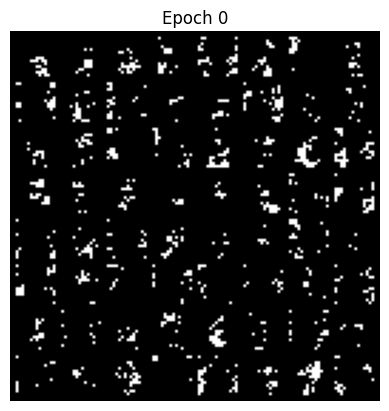

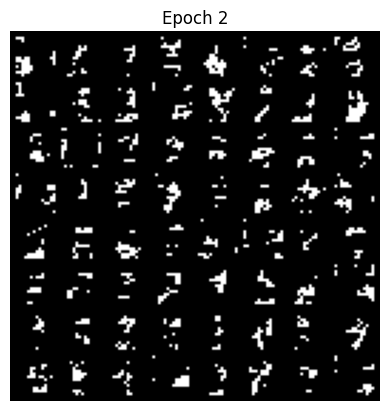

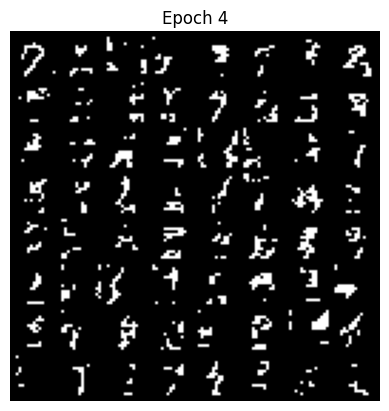

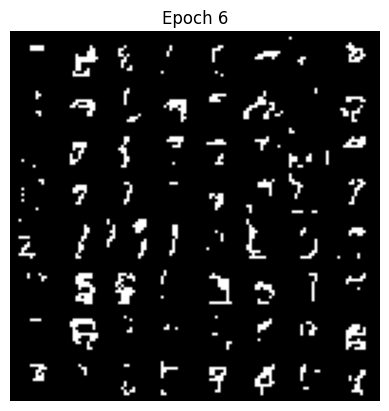

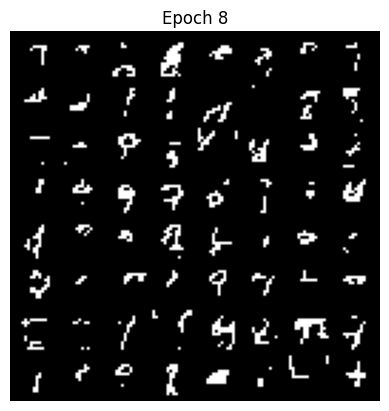

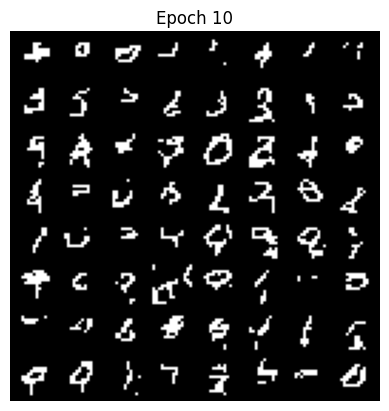

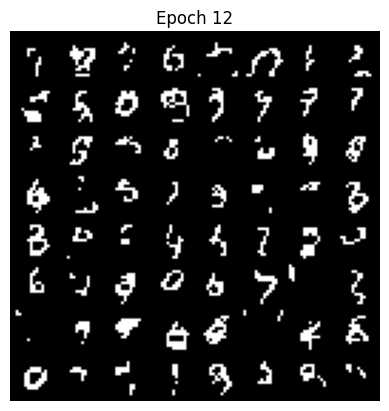

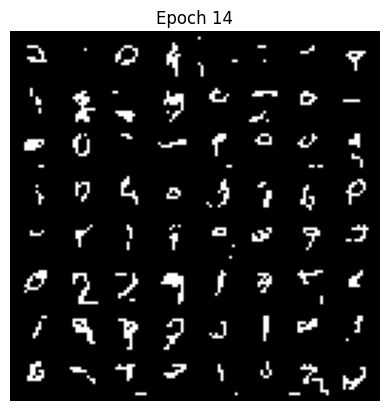

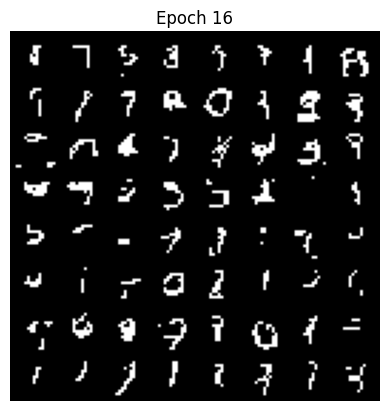

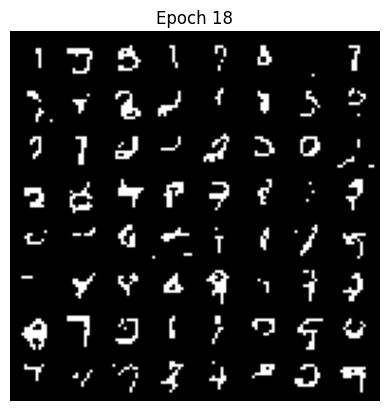

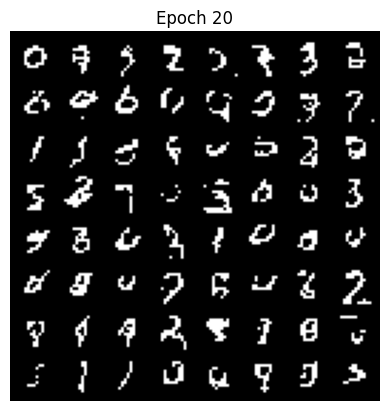

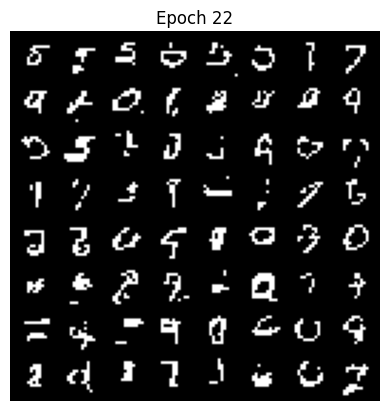

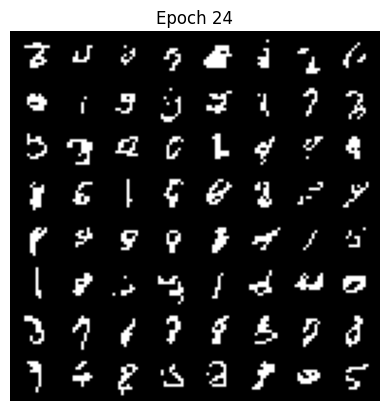

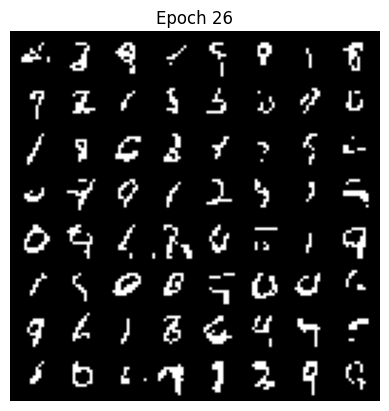

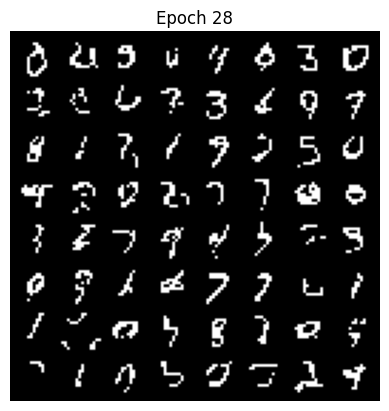

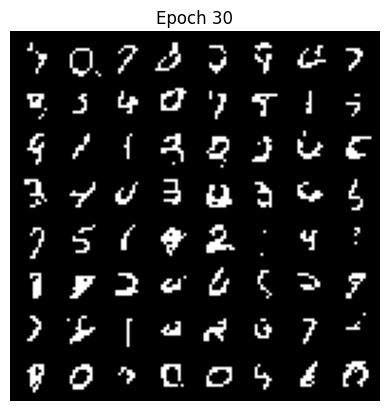

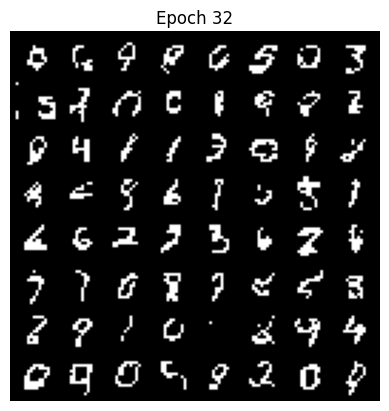

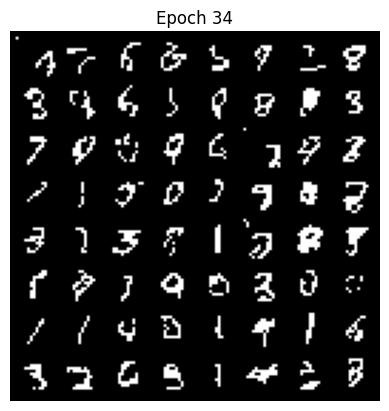

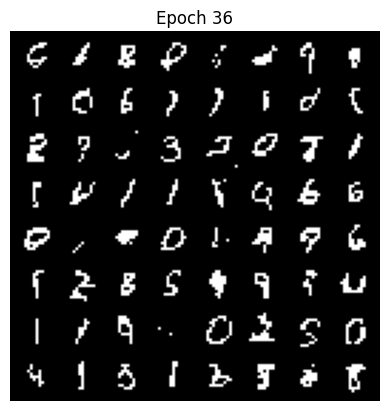

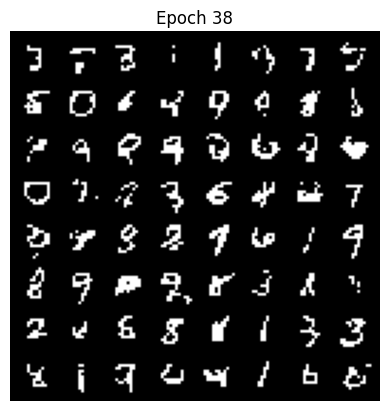

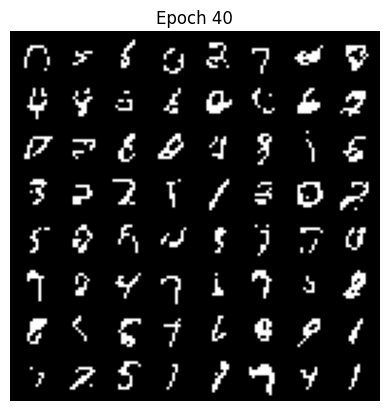

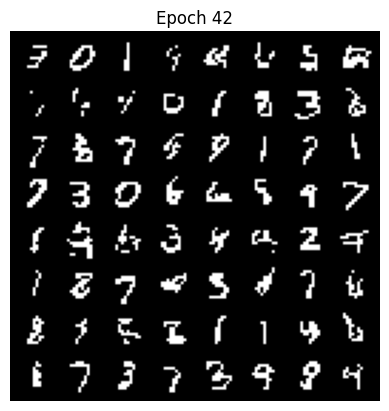

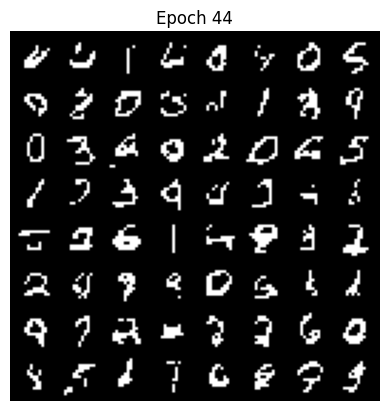

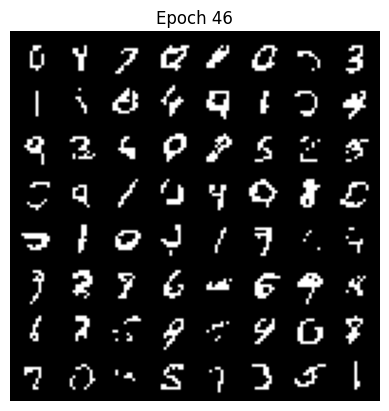

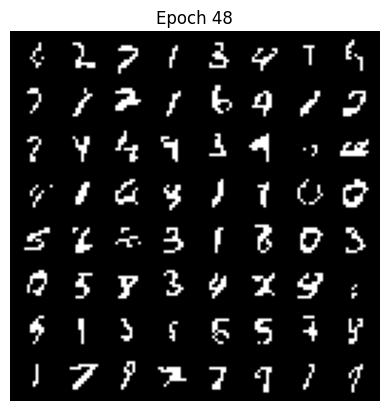

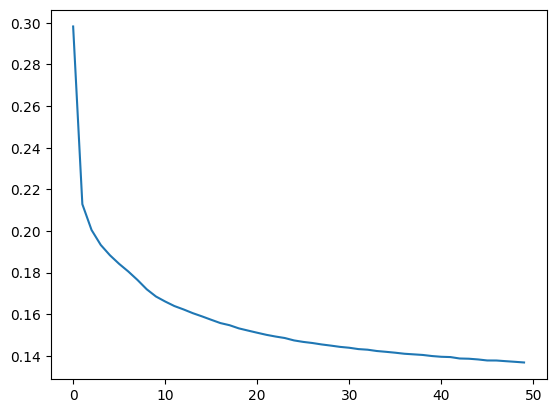

In [8]:
device = torch.device("cuda:0")

# Creates an instance of the RNN_Example class, passing the device as an argument to specify the device for computation. Moving the model to the GPU.
net = RNN_Example(device, append_loc=False).to(device)

# Setting the model in training mode. Enables certain behaviors such as dropout and batch normalization layers that are typically used during training but disabled during evaluation.
net.train()
epochs, lr = 50, 2e-4 # lr determines the step size at each iteration of the optimizer.

# Creates an instance if the Adam optimizer. It will be used to update the model's parameters during training, optimizing the loss function
optimizer = optim.Adam(net.parameters(), lr=lr)

ls = []
for epoch in range(epochs):

  train_losses = []
  for x in train_loader:
    x = 1.0*(x[0]>0.5).to(device)
    loss = net.nll(x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
  if epoch%2==0:
    samples = net.sample(64)
    visualize_batch(samples, title=f'Epoch {epoch}')
  ls.append(np.mean(train_losses))

plt.plot(ls)